EOmaps example 4: Turn your maps into a powerful widgets

In [1]:
%matplotlib widget
from eomaps import Maps
import pandas as pd
import numpy as np

In [2]:
# create some example data
lon, lat = np.meshgrid(np.linspace(-20, 40, 50), np.linspace(30, 60, 50))

data = pd.DataFrame(
    dict(lon=lon.flat, lat=lat.flat, data=np.sqrt(lon**2 + lat**2).flat)
)

D:\python_modules\eomaps\eomaps\eomaps.py:461: UserWarning: EOmaps disables matplotlib's interactive mode (e.g. 'plt.ioff()') when using the 'ipympl' backend to avoid recursions during callbacks!
  "EOmaps disables matplotlib's interactive mode (e.g. 'plt.ioff()') "


EOmaps: Parameter was set to: 'data'
EOmaps: estimating radius...
EOmaps: The estimated radius is: 0.3061


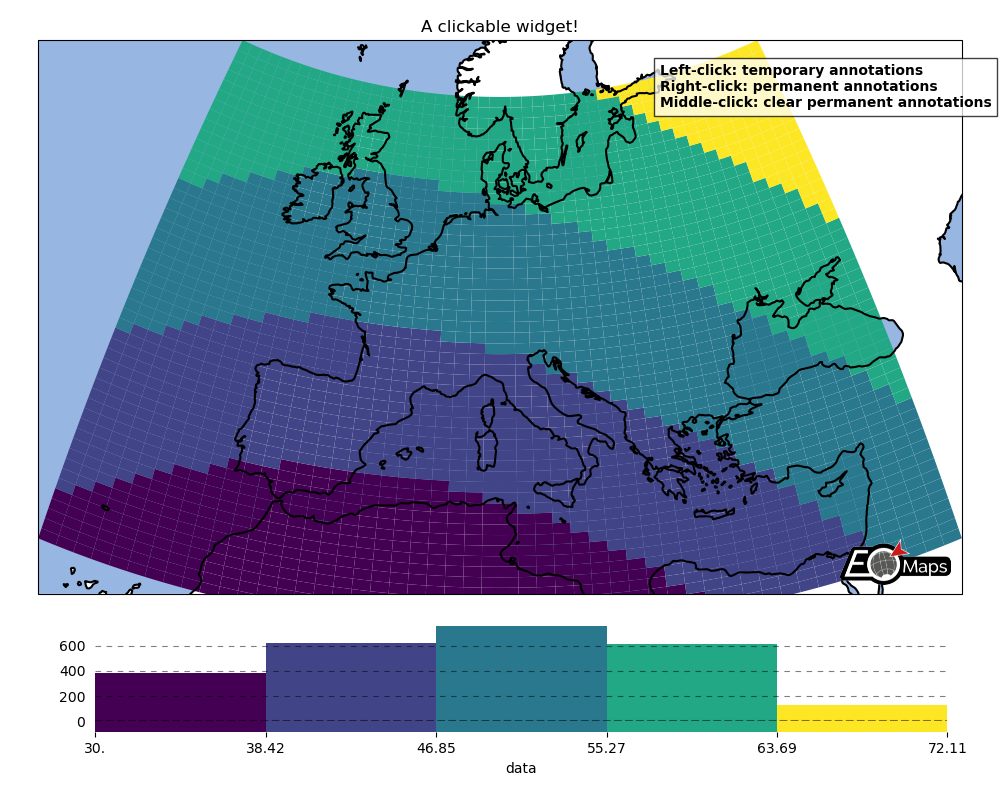

In [3]:
# --------- initialize a Maps object and plot a basic map
m = Maps(crs=3035, figsize=(10, 8))
m.set_data(data=data, xcoord="lon", ycoord="lat", in_crs=4326)
m.ax.set_title("A clickable widget!")
m.set_plot_specs(histbins="bins")
m.set_shape.rectangles()
# double the estimated radius in x-direction to make the plot dense
m.shape.radius = (m.shape.radius[0] * 2, m.shape.radius[1])

m.set_classify_specs(scheme="EqualInterval", k=5)
m.add_feature.preset.ocean()  # add ocean-coloring in the background
m.add_feature.preset.coastline()  # add coastlines on top
m.plot_map()

# --------- attach pre-defined CALLBACK funcitons ---------
# add a temporary annotation and a marker if you left-click on a pixel
m.cb.pick.attach.mark(
    button=1,
    permanent=False,
    fc=[0, 0, 0, 0.5],
    ec="w",
    ls="--",
    buffer=2.5,
    shape="ellipses",
    zorder=1,
)
m.cb.pick.attach.annotate(
    button=1,
    permanent=False,
    bbox=dict(boxstyle="round", fc="w", alpha=0.75),
    zorder=10,
)
### save all picked values to a dict accessible via m.cb.get.picked_vals
cid = m.cb.pick.attach.get_values(button=1)

# add a permanent marker if you right-click on a pixel
m.cb.pick.attach.mark(
    button=3,
    permanent=True,
    facecolor=[1, 0, 0, 0.5],
    edgecolor="k",
    buffer=1,
    shape="rectangles",
    zorder=1,
)

# add a customized permanent annotation if you right-click on a pixel
def text(m, ID, val, pos, ind):
    return f"ID={ID}"

cid = m.cb.pick.attach.annotate(
    button=3,
    permanent=True,
    bbox=dict(boxstyle="round", fc="r"),
    text=text,
    xytext=(10, 10),
    zorder=2,  # use zorder=2 to put the annotations on top of the markers
)

# remove all permanent markers and annotations if you middle-click anywhere on the map
cid = m.cb.pick.attach.clear_annotations(button=2)
cid = m.cb.pick.attach.clear_markers(button=2)
# --------- define a custom callback to update some text to the map
# (use a high zorder to draw the texts above all other things)

txt = m.figure.f.text(
    0.5,
    0.35,
    "You clicked on 0 pixels so far",
    fontsize=15,
    horizontalalignment="center",
    verticalalignment="top",
    color="w",
    fontweight="bold",
    animated=True,
    zorder=99,
)
txt2 = m.figure.f.text(
    0.18,
    0.9,
    "   lon    /    lat " + "\n",
    fontsize=12,
    horizontalalignment="right",
    verticalalignment="top",
    fontweight="bold",
    animated=True,
    zorder=99,
)

# add the custom text objects to the blit-manager (m.BM) to avoid re-drawing the whole<br>
# image if the text changes.
m.BM.add_artist(txt)
m.BM.add_artist(txt2)

def cb1(self, pos, ID, val, **kwargs):
    # update the text that indicates how many pixels we've clicked
    nvals = len(self.cb.pick.get.picked_vals["ID"])
    txt.set_text(
        f"You clicked on {nvals} pixel"
        + ("s" if nvals > 1 else "")
        + "!\n... and the "
        + ("average" if nvals > 1 else "")
        + f"value is {np.mean(self.cb.pick.get.picked_vals['val']):.3f}"
    )

    # update the list of lon/lat coordinates on the top left of the figure
    d = self.data.loc[ID]
    lonlat_list = txt2.get_text().splitlines()
    if len(lonlat_list) > 10:
        lonlat_txt = lonlat_list[0] + "\n" + "\n".join(lonlat_list[-10:]) + "\n"
    else:
        lonlat_txt = txt2.get_text()
    txt2.set_text(lonlat_txt + f"{d['lon']:.2f}  /  {d['lat']:.2f}" + "\n")

cid = m.cb.pick.attach(cb1, button=1)

def cb2(self, pos, ID, val, **kwargs):
    # plot a marker at the pixel-position
    (l,) = self.figure.ax.plot(*pos, marker="*", animated=True)
    # print the value at the pixel-position
    # use a low zorder so the text will be drawn below the temporary annotations
    t = self.figure.ax.text(
        pos[0],
        pos[1] - 150000,
        f"{val:.2f}",
        horizontalalignment="center",
        verticalalignment="bottom",
        color=l.get_color(),
        animated=True,
        zorder=1,
    )
    # add the artists to the Blit-Manager (m.BM) to avoid triggering a re-draw of the
    # whole figure each time the callback triggers
    self.BM.add_artist(l)
    self.BM.add_artist(t)

cid = m.cb.pick.attach(cb2, button=3)

# add some static text
infotext = (
    "Left-click: temporary annotations\n"
    + "Right-click: permanent annotations\n"
    + "Middle-click: clear permanent annotations"
)

_ = m.figure.f.text(
    0.66,
    0.92,
    infotext,
    fontsize=10,
    horizontalalignment="left",
    verticalalignment="top",
    color="k",
    fontweight="bold",
    bbox=dict(facecolor="w", alpha=0.75),
)

m.cb.click.attach.mark(
    fc="r", ec="none", radius=10000, shape="geod_circles", permanent=False
)
m.cb.click.attach.mark(
    fc="none", ec="r", radius=50000, shape="geod_circles", permanent=False
)

m.add_colorbar(bottom=0.05)
m.add_logo()